In [ ]:
# in this notebook we use a neural network with the following architecture
#
# 2-deep-layers-amplitude/phase
#
# the inputs will be 2 dimensional, (mass-ratio, model_name)
# 
# view this as a decoder network where we have chosen the latent space by hand

# lets see how well this does

# ... it seems to work very, very well

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import glob
import os

import tempfile
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt

# mpl.use("agg")

# from cycler import cycler
# from itertools import cycle

# mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

In [298]:
def load_training_data(root_dir):
    data = {}
    data['times']                  = np.load(os.path.join(f'{root_dir}', 'times.npy'))
    data['data_processing_params'] = np.load(os.path.join(f'{root_dir}', 'data_processing_params.npz'))
    data['phase']                  = np.load(os.path.join(f'{root_dir}', 'phase.npy'))
    data['mass_ratios']            = np.load(os.path.join(f'{root_dir}', 'mass-ratios.npy'))
    data['approximants']           = np.load(os.path.join(f'{root_dir}', 'approximants.npy'))
    data['amplitude']              = np.load(os.path.join(f'{root_dir}', 'amplitude.npy'))
    
    num_waveforms = data['amplitude'].shape[0]
    indicies = np.arange(num_waveforms)
    
    data['unique_approximants'] = np.unique(data['approximants'])
    
    # mask is a dictionary with keys the same as the approximants
    # this contains the indicies of each approximant
    data['mask'] = {}
    for k in data['unique_approximants']:
        data['mask'].update({k:indicies[k == data['approximants']]})
    
    return data

In [ ]:

# /Users/spx8sk/work/data/wispy-data/eob_phend_nr

# "/Users/spx8sk/work/data/wispy-data/add_phenC/training_data"

In [299]:
training_data = load_training_data(root_dir="/Users/spx8sk/work/data/wispy-data/add_phenC/training_data")

In [300]:
validation_data = load_training_data(root_dir="/Users/spx8sk/work/data/wispy-data/add_phenC/validation_data")

In [301]:
list(training_data)

['times',
 'data_processing_params',
 'phase',
 'mass_ratios',
 'approximants',
 'amplitude',
 'unique_approximants',
 'mask']

In [302]:
training_data['mask']

{'IMRPhenomC': array([200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212,
        213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225,
        226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238,
        239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251,
        252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264,
        265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277,
        278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290,
        291, 292, 293, 294, 295, 296, 297, 298, 299]),
 'IMRPhenomD': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89

In [303]:
def get_training_data(data):
    x_tmp = {}
    y_tmp = {}
    for i, approx in enumerate(data['unique_approximants']):
        print(f"working {approx}")
        mask = data['mask'][approx]
        num_cases = len(mask)
        qs = data['mass_ratios'][mask]
        names = np.repeat(i, num_cases)
        x_tmp[approx] = np.transpose((names, qs))
        y_tmp[approx] = data['amplitude'][mask]
        
    x = np.row_stack([x_tmp[approx] for approx in x_tmp.keys()])
    y = np.row_stack([y_tmp[approx] for approx in y_tmp.keys()])
    
    return x, y

In [304]:
x, y = get_training_data(training_data)
xval, yval = get_training_data(validation_data)

working IMRPhenomC
working IMRPhenomD
working NR
working SEOBNRv4_opt
working IMRPhenomC
working IMRPhenomD
working SEOBNRv4_opt


In [305]:
NR_NUM = float(np.where(training_data["unique_approximants"]=="NR")[0][0])
print(NR_NUM)

sample_weight = np.ones(len(y),)
sample_weight[x[:,0]==NR_NUM] = 20

2.0


In [306]:
sample_weight

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1

In [307]:
sample_weight.shape

(305,)

In [308]:
x.shape

(305, 2)

In [309]:
y.shape

(305, 4150)

In [310]:
xval.shape

(540, 2)

In [311]:
yval.shape

(540, 4150)

In [312]:
# x = (model_name, q)

In [313]:
def build_decoder(output_shape, latent_dim, units, acts):
    # build the decoder
    latent_input = keras.Input(shape=(latent_dim,))
    for i, (unit, act) in enumerate(zip(units, acts)):
        if i == 0:
            x = layers.Dense(unit, activation=act)(latent_input)
        else:
            x = layers.Dense(unit, activation=act)(x)
    timeseries_output = layers.Dense(output_shape, activation="linear")(x)
    decoder_model = keras.Model(latent_input, timeseries_output)
#     print("=" * 20)
#     print("decoder summary")
#     print("=" * 20)
#     decoder_model.summary()

    return decoder_model


In [314]:
def initial_fit(model, x, y, validation_data=None, epochs=10000, batch_size=100, validation_freq=100, lr=None, sample_weight=None):
        
    loss = 'mae'
    metrics = ['mse']

    if lr == None:
        boundaries = [5000, 5100]
        values = [1e-3, 1e-4, 1e-5]
        # boundaries = [500, 600]
        # values = [1e-3, 1e-4, 1e-5]
        learning_rate_fn = keras.optimizers.schedules.PiecewiseConstantDecay(
            boundaries, values)
        opt = tf.keras.optimizers.Adam(learning_rate_fn)
    else:
        opt = tf.keras.optimizers.Adam(lr)

    model.compile(optimizer=opt, loss=loss, metrics=metrics)

    callbacks=[]
    tqdm_callback = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
    callbacks.append(tqdm_callback)

    history = model.fit(
        x=x,
        y=y,
        epochs=epochs,
        callbacks=callbacks,
        verbose=0,
        batch_size=batch_size,
        validation_data=validation_data,
        validation_freq=validation_freq,
        sample_weight=sample_weight
    )

    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['mse'], label='mse')
    plt.yscale('log')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['val_mse'], label='val_mse')

    plt.yscale('log')
    plt.legend()
    
    return history, model


CPU times: user 17min 22s, sys: 5min 59s, total: 23min 21s
Wall time: 5min 30s


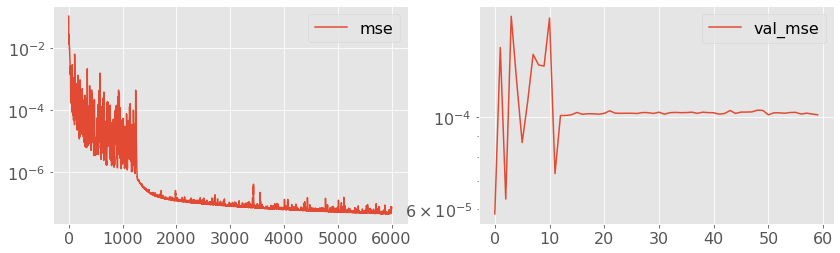

In [317]:
%%time

output_shape = y.shape[1]
latent_dim = 2

decoder_units = [16, 128, 512]
decoder_acts = ['relu', 'relu', 'relu']

# decoder_units = [16, 128]
# decoder_acts = ['relu', 'relu']

# decoder_units = [16, 128, 128, 128]
# decoder_acts = ['relu', 'relu', 'relu', 'relu']

model = build_decoder(output_shape, latent_dim, decoder_units, decoder_acts)

history, model = initial_fit(
    model,
    x=x,
    y=y,
    validation_data=(xval, yval),
    epochs=6000,
    batch_size=100,
    validation_freq=100,
    lr=None,
    sample_weight=sample_weight
)

In [364]:
def compare_models(y, index):
    
    times = training_data['times']
    
    yhat = model.predict(x)[index]
    
    y = y[index]
    
    plt.figure(figsize=(18, 10))
    plt.subplot(2, 1, 1)
    plt.plot(times, y, label='true')
    plt.plot(times, yhat, label='yhat')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlim(-200, 20)
#     plt.ylim(0.4, 0.9)
    
    plt.subplot(2, 1, 2)
    plt.plot(times, y-yhat, label='y-yhat')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.ylim(-0.01,0.01)
    
    title = f"(approx,q)={np.around(x[index], 3)}"
    plt.suptitle(title)

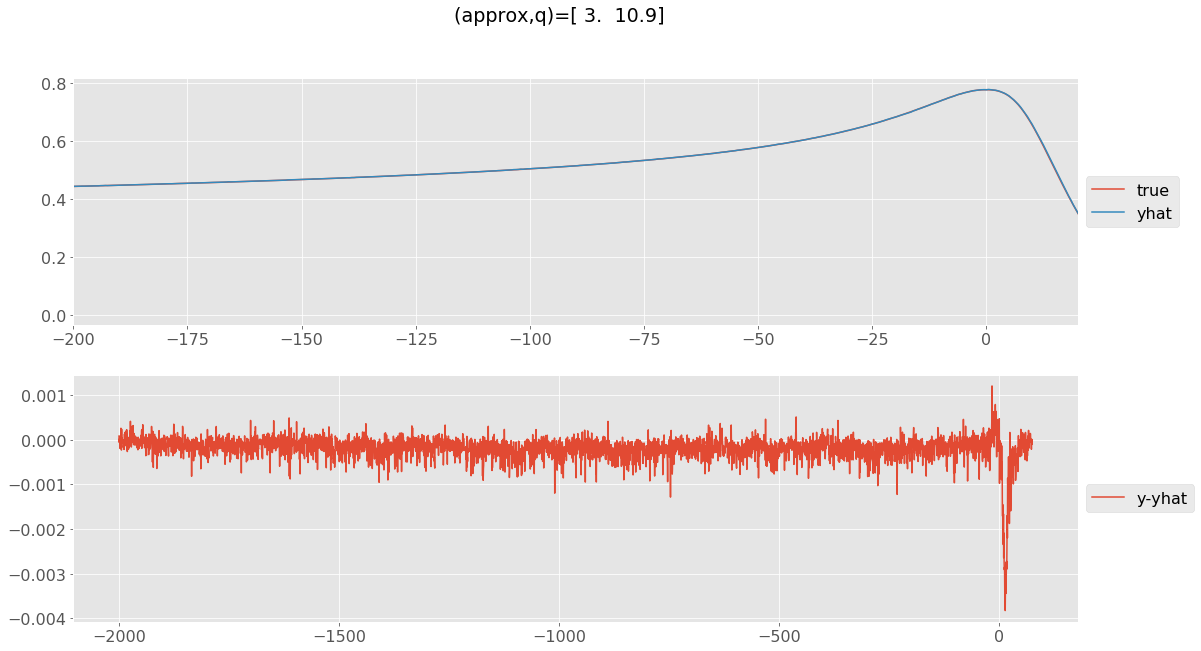

In [382]:
compare_models(y, -1)

In [358]:
def predict(qs, ns):
    """
    qs: 1d array of mass-ratios
    ns: 1d array of model numbers ranging from 0 to 2, inclusive
    """
    
    inputs = np.column_stack((ns, qs))
    
    yhats = model.predict(inputs)
    times = training_data['times']
    
    plt.figure(figsize=(18, 8))
    for yhat in yhats:
        plt.plot(times, yhat)
#     plt.yscale('log')
#     plt.xlim(-100, 20)
#     plt.ylim(0.4, 0.8)
    plt.show()
    plt.close()

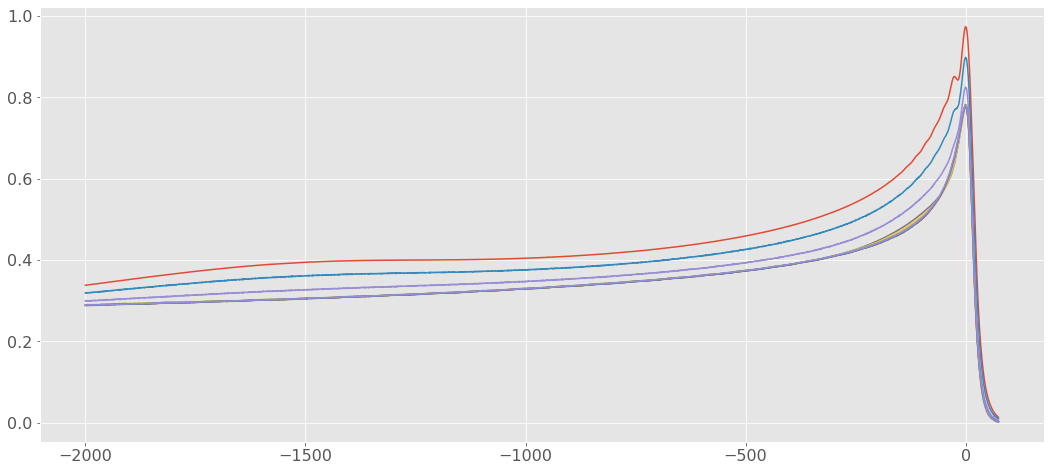

In [359]:
qs = np.repeat(10, 10)
ns = np.linspace(0, 3, len(qs))
# ns = np.linspace(1, 3, len(qs))
# qs = np.repeat(3, 3)
# ns = np.array([0,1,2])
predict(qs, ns)

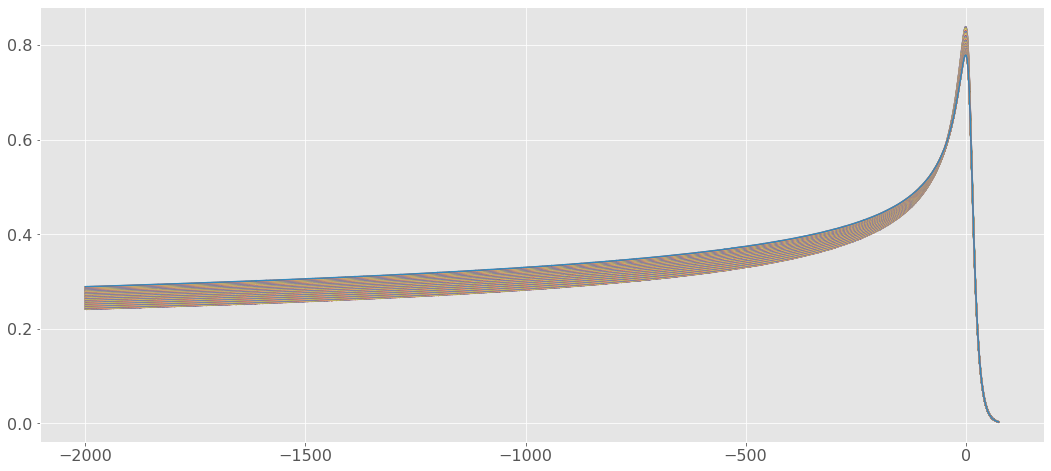

In [360]:
qs = np.linspace(1, 10, 100)
ns = np.repeat(3, len(qs))
predict(qs, ns)